# Sentiment Analysis - NLP Assigment1

This notebook **preserves emojis** (as tokens using `emoji.demojize`) and applies Indonesian preprocessing with **Sastrawi stopwords + stemming**, then trains **TF‑IDF + Logistic Regression / MultinomialNB**.

In [3]:
# ===== Setup & Drive Mount =====

!pip -q install Sastrawi scikit-learn matplotlib pandas joblib emoji==2.10.0

from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import os, re, json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt

# Emoji & Indonesian NLP
import emoji
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Paths
DATA_PATH = "/content/drive/MyDrive/Proyek/Data/tweet.csv"  # adjust if needed
OUTPUT_DIR = Path("/content/drive/MyDrive/Proyek/SentimentFinalEnhancedNew")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('DATA_PATH:', DATA_PATH)
print('OUTPUT_DIR:', OUTPUT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATA_PATH: /content/drive/MyDrive/Proyek/Data/tweet.csv
OUTPUT_DIR: /content/drive/MyDrive/Proyek/SentimentFinalEnhancedNew


In [4]:
# ===== Load Dataset =====
df = pd.read_csv(DATA_PATH)

# Drop index-like column if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Basic checks
assert {"tweet", "sentimen"}.issubset(df.columns), "Columns 'tweet' and 'sentimen' must exist"

print(df.shape)
df.head()

(1815, 2)


,sentimen,tweet
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...


In [5]:
# ===== Preprocessing: Keep Emojis, Clean, Stopwords, Stemming (Sastrawi) =====
# Build Sastrawi tools
stemmer = StemmerFactory().create_stemmer()
stop_factory = StopWordRemoverFactory()
indo_stop = set(stop_factory.get_stop_words())

# Optionally extend stopwords with casual Indonesian tokens
extra_stops = {"yg","aja","kok","nih","sih","dong","nya","nyaa","krn","karna","karena","ttp","tetep"}
indo_stop |= extra_stops

def basic_clean_with_emoji(text: str) -> str:
    text = str(text).lower()
    # Remove URLs, keep mentions and hashtags (predictive for topics/actors)
    text = re.sub(r"http\S+|www\S+", " ", text)
    # Convert emojis into text tokens, e.g., 😡 -> emoji_angry_face
    text = emoji.demojize(text, delimiters=(" emoji_", ""))
    # Keep letters, hashtags, mentions, underscores from demojize
    text = re.sub(r"[^a-z@#\s_]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def simplify_emoji_tokens(text: str) -> str:
    # Optional: group common positive/negative emoji variants to avoid sparsity
    text = re.sub(r"emoji_(?:face_with_tears_of_joy|grinning|smile|smiling_face|smiling_face_with_heart_eyes|heart_eyes|rolling_on_the_floor_laughing|sparkles|thumbs_up)", " emoji_positive ", text)
    text = re.sub(r"emoji_(?:angry|pouting|rage|cry|sob|disappointed|frowning|persevering_face|downcast_face_with_sweat|thumbs_down|weary)", " emoji_negative ", text)
    return text

def preprocess_id(text: str) -> str:
    t = basic_clean_with_emoji(text)
    t = simplify_emoji_tokens(t)
    # stopword removal (token-wise)
    tokens = [w for w in t.split() if w not in indo_stop]
    t = " ".join(tokens)
    # stemming (note: Sastrawi expects Indonesian words; emoji_* tokens are left untouched)
    t = stemmer.stem(t)
    # collapse whitespace again
    t = re.sub(r"\s+", " ", t).strip()
    return t

# Apply
df["text_clean"] = df["tweet"].apply(preprocess_id)

# Quick sanity check (show original vs processed)
df[["tweet","text_clean"]].head(5)

,tweet,text_clean
0,Kata @prabowo Indonesia tidak dihargai bangsa ...,kata prabowo indonesia harga bangsa asing beri...
1,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batu langka tasbih jokowi hadiah habib luthfi ...
2,"Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia makin baik indone...
3,"Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asi games dampak pd ekonomi l...
4,Negara kita ngutang buat bngun infrastruktur y...,negara ngutang buat bngun infrastruktur udah d...


In [6]:
# ===== Train / Test Split =====
X = df["text_clean"].values
y = df["sentimen"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (1452,) Test: (363,)


In [7]:
# ===== TF-IDF Vectorizer =====
# Keep 1-2 grams to let emoji tokens combine with nearby words if helpful
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95,
    max_features=30000,
    sublinear_tf=True
)


In [8]:
# ===== Pipelines & Training =====
pipe_mnb = Pipeline([
    ("tfidf", tfidf),
    ("clf", MultinomialNB(alpha=1.0))
])

pipe_lr = Pipeline([
    ("tfidf", tfidf),
    ("clf", LogisticRegression(C=2.0, penalty="l2", solver="liblinear", max_iter=200))
])

pipe_mnb.fit(X_train, y_train)
pipe_lr.fit(X_train, y_train)

print("Models trained.")

Models trained.


In [9]:
# ===== Evaluation =====
def evaluate_model(name, pipe):
    y_pred_tr = pipe.predict(X_train)
    y_pred_te = pipe.predict(X_test)
    f1_tr = f1_score(y_train, y_pred_tr, average="macro")
    f1_te = f1_score(y_test, y_pred_te, average="macro")
    report = classification_report(y_test, y_pred_te, digits=3, output_dict=False)
    print(f"\n=== {name} ===")
    print("Macro F1 (train):", round(f1_tr, 4))
    print("Macro F1 (test) :", round(f1_te, 4))
    print(report)
    return {
        "model": name,
        "f1_train_macro": f1_tr,
        "f1_test_macro": f1_te,
        "y_pred_test": y_pred_te
    }

res_mnb = evaluate_model("MultinomialNB", pipe_mnb)
res_lr  = evaluate_model("LogisticRegression", pipe_lr)

import pandas as pd
results_df = pd.DataFrame([
    {"Model": "MultinomialNB", "F1_macro_train": res_mnb["f1_train_macro"], "F1_macro_test": res_mnb["f1_test_macro"]},
    {"Model": "LogisticRegression", "F1_macro_train": res_lr["f1_train_macro"], "F1_macro_test": res_lr["f1_test_macro"]},
])
results_df


=== MultinomialNB ===
Macro F1 (train): 0.8467
Macro F1 (test) : 0.59
              precision    recall  f1-score   support

     negatif      0.559     0.639     0.596       119
      netral      0.660     0.562     0.607       121
     positif      0.565     0.569     0.567       123

    accuracy                          0.590       363
   macro avg      0.595     0.590     0.590       363
weighted avg      0.595     0.590     0.590       363


=== LogisticRegression ===
Macro F1 (train): 0.9222
Macro F1 (test) : 0.6244
              precision    recall  f1-score   support

     negatif      0.613     0.706     0.656       119
      netral      0.640     0.603     0.621       121
     positif      0.625     0.569     0.596       123

    accuracy                          0.625       363
   macro avg      0.626     0.626     0.624       363
weighted avg      0.626     0.625     0.624       363



,Model,F1_macro_train,F1_macro_test
0,MultinomialNB,0.846711,0.590008
1,LogisticRegression,0.922161,0.624424


from matplotlib import pyplot as plt
results_df['F1_macro_train'].plot(kind='hist', bins=20, title='F1_macro_train')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['F1_macro_test'].plot(kind='hist', bins=20, title='F1_macro_test')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='F1_macro_train', y='F1_macro_test', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['F1_macro_train']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'F1_macro_train'}, axis=1)
              .sort_values('F1_macro_train', ascending=True))
  xs = counted['F1_macro_train']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('F1_macro_train', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('F1_macro_train')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['F1_macro_test']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'F1_macro_test'}, axis=1)
              .sort_values('F1_macro_test', ascending=True))
  xs = counted['F1_macro_test']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('F1_macro_test', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('F1_macro_test')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
results_df['F1_macro_train'].plot(kind='line', figsize=(8, 4), title='F1_macro_train')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['F1_macro_test'].plot(kind='line', figsize=(8, 4), title='F1_macro_test')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='F1_macro_train', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='F1_macro_test', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Best model: LogisticRegression | Macro F1 (test): 0.6244


<Figure size 500x400 with 0 Axes>

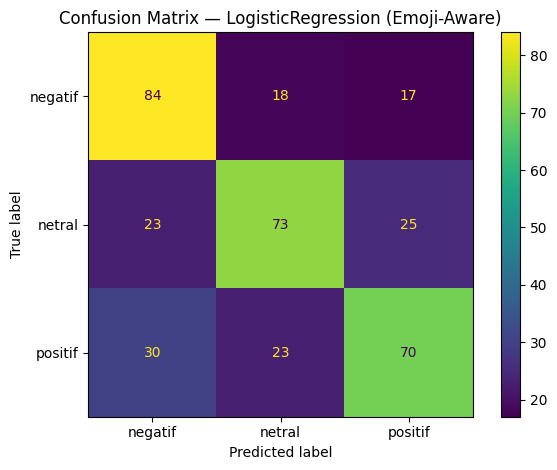

Confusion matrix saved to: /content/drive/MyDrive/Proyek/SentimentFinalEnhancedNew/confusion_matrix_LogisticRegression_emoji.png
Saved best pipeline to: /content/drive/MyDrive/Proyek/SentimentFinalEnhancedNew/model_LogisticRegression_emoji.joblib
Saved comparison table to: /content/drive/MyDrive/Proyek/SentimentFinalEnhancedNew/model_comparison_emoji.csv


In [12]:
# ===== Confusion Matrix (Best) & Save Artifacts =====
best = max([res_mnb, res_lr], key=lambda d: d["f1_test_macro"])
best_name = best["model"]
best_pipe = pipe_mnb if best_name == "MultinomialNB" else pipe_lr

print("Best model:", best_name, "| Macro F1 (test):", round(best["f1_test_macro"], 4))

# Confusion matrix
labels_sorted = sorted(np.unique(y))
cm = confusion_matrix(y_test, best["y_pred_test"], labels=labels_sorted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)

plt.figure(figsize=(5,4))
disp.plot(values_format='d')
plt.title(f"Confusion Matrix — {best_name} (Emoji-Aware)")
plt.tight_layout()
cm_path = OUTPUT_DIR / f"confusion_matrix_{best_name}_emoji.png"
plt.savefig(cm_path, dpi=200)
plt.show()
print("Confusion matrix saved to:", cm_path)

# Save best model (pipeline contains TF-IDF so it's ready-to-use)
model_path = OUTPUT_DIR / f"model_{best_name}_emoji.joblib"
import joblib
joblib.dump(best_pipe, model_path)
print("Saved best pipeline to:", model_path)

# Save comparison table
results_csv = OUTPUT_DIR / "model_comparison_emoji.csv"
results_df.to_csv(results_csv, index=False)
print("Saved comparison table to:", results_csv)